In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import os
import numpy as np
import sklearn.cross_validation as xval
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

DATAPATH = '../data'
dataset = pd.read_csv(os.path.join(DATAPATH, "autosomal_perlocus_train_intergenic.bed.gz"), sep="\t").drop_duplicates()

In [2]:
dataset.head()

,chrom,start,end,ml_mu,ml_beta,ml_p,ml_mu_stderr,numsamples,strfilter,motif,length,uninterrupted_length,recomb,gc,entropy,reptiming,featurefilter
0,1,6240216,6240230,-7.673910,0.173510,0.999827,46.962810,276,PASS,C,15,15,0.179823,0.76,1.775127,1.624147,False
2,1,6242999,6243010,-5.919316,0.309188,0.700034,1.624597,301,PASS,A,12,12,0.179823,0.48,1.979462,1.627233,False
4,1,6261638,6261657,-6.801359,0.155284,0.999998,2.420272,297,PASS,AAAAC,20,20,6.985400,0.52,1.981485,1.641989,False
6,1,6262655,6262669,-7.674328,0.407779,0.826899,0.000000,297,PASS,AAAT,15,15,6.985400,0.57,1.943314,1.641989,False
8,1,6263398,6263418,-7.674330,0.062093,0.957393,0.000000,300,PASS,AATG,21,11,1.181490,0.45,1.969031,1.642892,False


In [3]:
dataset['period'] = dataset['motif'].str.len()
print max(dataset['period'])

6


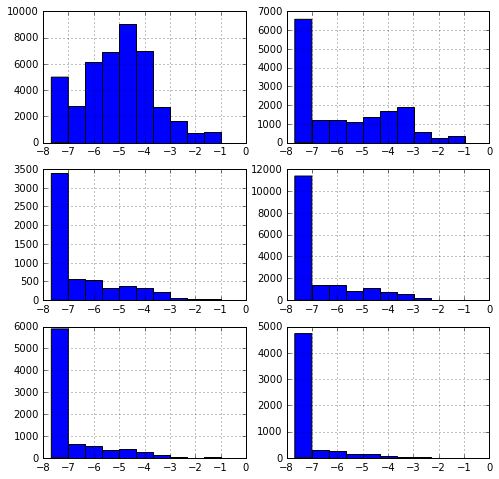

In [4]:
fig, ((axis1, axis2), (axis3, axis4), (axis5, axis6)) = plt.subplots(3,2, figsize=(8, 8))
for i in range(1, 7):
    axes = [axis1, axis2, axis3, axis4, axis5, axis6]
    dataset[dataset['period']==i]['ml_mu'].hist(ax=axes[i-1])

The above figure indicates that the data is unbalanced, especially for those data whose motif length is greater than 1, the amount of data with **ml_mu < -7** is too large. And since **ml_mu < -7** usually indicates the estimation is not accurate, so those data will greatly affect our prediction, thus should be dropped or resampled.

Try drop firtst, then try resample.

In [5]:
dataset = dataset[dataset['ml_mu'] > -6][dataset['ml_mu'] < -3]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


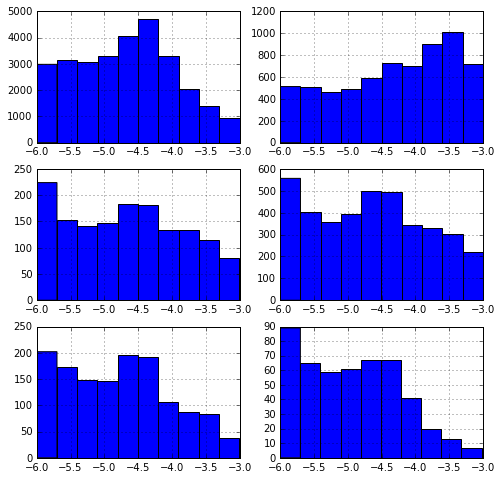

In [6]:
fig2, ((axis1, axis2), (axis3, axis4), (axis5, axis6)) = plt.subplots(3,2, figsize=(8, 8))
for i in range(1, 7):
    axes = [axis1, axis2, axis3, axis4, axis5, axis6]
    dataset[dataset['period']==i]['ml_mu'].hist(ax=axes[i-1])

In [7]:
basic_X = dataset[['uninterrupted_length', 'period']][:15000]
basic_y = dataset['ml_mu'][:15000]
train_X, test_X, train_y, test_y = xval.train_test_split(basic_X, basic_y, test_size=0.25)

# Linear Regression

0.163070433885
(0.40389739012091719, 3.6831798932562232e-147)


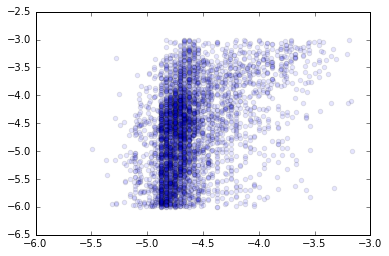

In [8]:
lr = LinearRegression()
lr.fit(train_X, train_y)
print lr.score(test_X, test_y)
plt.scatter(lr.predict(test_X), test_y, alpha=0.1)
print pearsonr(test_y, lr.predict(test_X))

# Random Forest

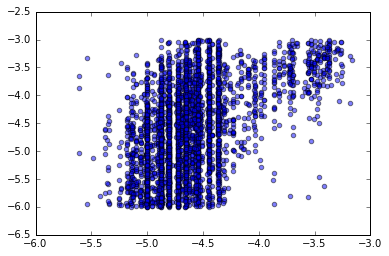

0.22542820262
(0.47508097357474649, 1.785537460026367e-210)


In [9]:
rf = RandomForestRegressor(max_depth=50, min_samples_leaf=2)
# weights = np.array([0.1 if mu < -5 else 1 for mu in train_X['period']])
rf.fit(train_X, train_y)
pred_y = rf.predict(test_X)
plt.scatter(pred_y, test_y, alpha=0.5)
plt.show()
print rf.score(test_X, test_y)
print pearsonr(test_y, pred_y)

In [10]:
import forestci as fci

inbag = fci.calc_inbag(train_X[:20000].shape[0], rf)
unbiased = fci.random_forest_error(rf, inbag, train_X[:20000], test_X[:20000])

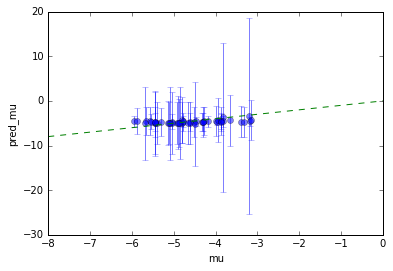

In [11]:
plot_size = 50

plt.errorbar(test_y[:plot_size], pred_y[:plot_size], yerr=np.sqrt(unbiased[:plot_size]), fmt='o', alpha=0.5)
plt.plot([-8, 0], [-8, 0], '--')
plt.xlabel('mu')
plt.ylabel('pred_mu')
plt.show()

In [12]:
rf.feature_importances_

array([ 0.67456435,  0.32543565])

In [13]:
dataset = pd.read_csv(os.path.join(DATAPATH, "autosomal_perlocus_train_intergenic.bed.gz"), sep="\t").drop_duplicates()

In [14]:
dataset['period'] = dataset['motif'].str.len()
dataset['pred_mu'] = rf.predict(dataset[['uninterrupted_length', 'period']])

In [15]:
header = ['chrom','start','end','ml_mu','ml_beta','ml_p','ml_mu_stderr','numsamples','strfilter','motif',
          'length','uninterrupted_length','recomb','gc,entropy','reptiming','featurefilter','period','pred_mu']
dataset.to_csv(os.path.join(DATAPATH, 'alex_rough_mu_prediction.csv'), columns=header, index=False)

In [16]:
dataset.head()

,chrom,start,end,ml_mu,ml_beta,ml_p,ml_mu_stderr,numsamples,strfilter,motif,length,uninterrupted_length,recomb,gc,entropy,reptiming,featurefilter,period,pred_mu
0,1,6240216,6240230,-7.673910,0.173510,0.999827,46.962810,276,PASS,C,15,15,0.179823,0.76,1.775127,1.624147,False,1,-4.655068
2,1,6242999,6243010,-5.919316,0.309188,0.700034,1.624597,301,PASS,A,12,12,0.179823,0.48,1.979462,1.627233,False,1,-4.873888
4,1,6261638,6261657,-6.801359,0.155284,0.999998,2.420272,297,PASS,AAAAC,20,20,6.985400,0.52,1.981485,1.641989,False,5,-4.921870
6,1,6262655,6262669,-7.674328,0.407779,0.826899,0.000000,297,PASS,AAAT,15,15,6.985400,0.57,1.943314,1.641989,False,4,-5.131518
8,1,6263398,6263418,-7.674330,0.062093,0.957393,0.000000,300,PASS,AATG,21,11,1.181490,0.45,1.969031,1.642892,False,4,-4.925490
